In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import glob
import os
import statsmodels as sm
from statsmodels.tsa.stattools import adfuller, acf, pacf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
Matplotlib is building the font cache; this may take a moment.


In [2]:
data_1 = pd.read_csv("/Volumes/TwoTeras/0_Experiment_1/Entropy_Results/entropy_log_Window_reduced.csv")
data_2 = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/entropy_log_Window_reduced.csv")
data_1.drop_duplicates(inplace=True)
data_2.drop_duplicates(inplace=True)

In [3]:
stacked_df = pd.concat([data_1,data_2])

In [4]:
stacked_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10536 entries, 0 to 5612
Data columns (total 17 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Trial_ID                                      10536 non-null  object 
 1   Collider_Name                                 10536 non-null  object 
 2   Occurrence_Order                              10536 non-null  int64  
 3   Gaze_Sequence_Length                          10536 non-null  int64  
 4   Chao_Shen_Overall_Transition_Entropy          10536 non-null  float64
 5   Window_Start                                  10536 non-null  object 
 6   Window_End                                    10536 non-null  object 
 7   Chao_Shen_Transition_Entropy_Agent            10536 non-null  float64
 8   Chao_Shen_Transition_Entropy_Task_Building    10139 non-null  float64
 9   Chao_Shen_Transition_Entropy_Background       10509 non-null  float

In [5]:
data_2.head()

,Trial_ID,Collider_Name,Occurrence_Order,Gaze_Sequence_Length,Chao_Shen_Overall_Transition_Entropy,Window_Start,Window_End,Chao_Shen_Transition_Entropy_Agent,Chao_Shen_Transition_Entropy_Background,Chao_Shen_Transition_Entropy_Task_Building,Chao_Shen_Transition_Entropy_Building,Chao_Shen_Transition_Entropy_Global_Landmark,Participant_ID,Session,Agent_ID,Agent_Type,Experiment
0,01_Cma_Trial_22,01_Cma,22,101,0.656785,2022-11-14 15:05:49.643743488,2022-11-14 15:06:19.643743488,0.413817,0.796446,0.542213,0.638921,NaN,1031,1,1,Active,2
1,03_Cma_Trial_16,03_Cma,16,105,0.420180,2022-11-14 15:05:49.643743488,2022-11-14 15:06:19.643743488,0.593945,0.383358,NaN,0.578749,NaN,1031,1,3,Active,2
2,09_Cma_Trial_14,09_Cma,14,120,0.338976,2022-11-14 15:05:49.643743488,2022-11-14 15:06:19.643743488,0.440854,0.250277,0.774386,0.448220,NaN,1031,1,9,Active,2
3,09_Cma_Trial_24,09_Cma,24,103,0.388994,2022-11-14 15:05:49.643743488,2022-11-14 15:06:19.643743488,0.000000,0.307365,0.829424,0.581089,0.662497,1031,1,9,Active,2
4,09_Cma_Trial_26,09_Cma,26,104,0.420628,2022-11-14 15:05:49.643743488,2022-11-14 15:06:19.643743488,0.662497,0.367091,0.781214,0.605045,0.000000,1031,1,9,Active,2


In [6]:
# Sort the data
stacked_df_ordered = stacked_df.sort_values(by=["Participant_ID", "Session", "Window_Start"]).reset_index(drop=True)


# Create Encounter_Order
stacked_df_ordered["Encounter_Order"] = (
    stacked_df_ordered.groupby(["Participant_ID", "Session", "Agent_ID"])
    .cumcount() + 1
)

# Create Cummulative Encounter_Order
stacked_df_ordered["Encounter_Order_Cummulative"] = (
    stacked_df_ordered.groupby(["Participant_ID", "Agent_ID"])
    .cumcount() + 1
)

In [7]:
# Step 1: Remove rows where 'Chao_Shen_Overall_Transition_Entropy' is NaN
filtered_df = stacked_df_ordered.dropna(subset=['Chao_Shen_Overall_Transition_Entropy'])

# Step 2: Ensure that only valid participant-experiment pairs exist
valid_combinations = filtered_df[['Agent_ID', 'Agent_Type', 'Participant_ID', 'Experiment']].drop_duplicates()

# Step 3: Perform aggregation only on valid data
grouped_for_LMM = filtered_df.groupby(
    ['Agent_ID', 'Agent_Type', 'Participant_ID', 'Experiment']
)['Chao_Shen_Overall_Transition_Entropy'].agg(['min', 'max', 'median', 'mean']).reset_index()

grouped_for_LMM.to_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/grouped_for_LMM_Chao_Shen.csv")
grouped_for_LMM.head()

,Agent_ID,Agent_Type,Participant_ID,Experiment,min,max,median,mean
0,1,Active,365,1,0.425134,0.623664,0.472700,0.507166
1,1,Active,479,1,0.350186,0.718303,0.476019,0.511759
2,1,Active,1031,2,0.438070,0.656785,0.639706,0.598253
3,1,Active,1142,2,0.420527,0.779954,0.660634,0.648967
4,1,Active,1234,2,0.357585,0.694609,0.613719,0.569908


In [8]:
stacked_df_ordered.tail()

,Trial_ID,Collider_Name,Occurrence_Order,Gaze_Sequence_Length,Chao_Shen_Overall_Transition_Entropy,Window_Start,Window_End,Chao_Shen_Transition_Entropy_Agent,Chao_Shen_Transition_Entropy_Task_Building,Chao_Shen_Transition_Entropy_Background,Chao_Shen_Transition_Entropy_Building,Chao_Shen_Transition_Entropy_Global_Landmark,Participant_ID,Session,Agent_ID,Agent_Type,Experiment,Encounter_Order,Encounter_Order_Cummulative
10531,40_Sa_Trial_7,40_Sa,7,104,0.440250,2022-11-16 08:03:24.911734016,2022-11-16 08:03:54.911734016,0.000000,0.000000,0.450060,0.430179,0.439337,9627,5,40,Passive,2,2,5
10532,47_Sa_Trial_29,47_Sa,29,107,0.466728,2022-11-16 08:03:24.911734016,2022-11-16 08:03:54.911734016,0.000000,0.433454,0.411705,0.666405,NaN,9627,5,47,Passive,2,1,4
10533,49_Sa_Trial_12,49_Sa,12,82,0.738674,2022-11-16 08:03:24.911734016,2022-11-16 08:03:54.911734016,0.000000,0.718980,0.744449,0.748254,NaN,9627,5,49,Passive,2,1,2
10534,52_Sa_Trial_27,52_Sa,27,101,0.747813,2022-11-16 08:03:24.911734016,2022-11-16 08:03:54.911734016,0.484839,0.719822,0.746014,0.836732,NaN,9627,5,52,Passive,2,1,3
10535,55_Sa_Trial_23,55_Sa,23,108,0.573269,2022-11-16 08:03:24.911734016,2022-11-16 08:03:54.911734016,1.271909,1.045423,0.407297,0.854244,NaN,9627,5,55,Passive,2,1,3


In [9]:
# Convert necessary columns to appropriate types
stacked_df_ordered["Session"] = stacked_df_ordered["Session"].astype(int)
stacked_df_ordered["Occurrence_Order"] = stacked_df_ordered["Occurrence_Order"].astype(int)
stacked_df_ordered["Chao_Shen_Overall_Transition_Entropy"] = stacked_df_ordered["Chao_Shen_Overall_Transition_Entropy"].astype(float)

In [10]:
stacked_df_ordered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10536 entries, 0 to 10535
Data columns (total 19 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Trial_ID                                      10536 non-null  object 
 1   Collider_Name                                 10536 non-null  object 
 2   Occurrence_Order                              10536 non-null  int64  
 3   Gaze_Sequence_Length                          10536 non-null  int64  
 4   Chao_Shen_Overall_Transition_Entropy          10536 non-null  float64
 5   Window_Start                                  10536 non-null  object 
 6   Window_End                                    10536 non-null  object 
 7   Chao_Shen_Transition_Entropy_Agent            10536 non-null  float64
 8   Chao_Shen_Transition_Entropy_Task_Building    10139 non-null  float64
 9   Chao_Shen_Transition_Entropy_Background       10509 non-null 

In [11]:
stacked_df_ordered.Encounter_Order_Cummulative.value_counts()

Encounter_Order_Cummulative
1     3051
2     2549
3     1881
4     1269
5      795
6      453
7      237
8      126
9       74
10      40
11      24
12      11
13       8
14       6
15       5
16       3
17       2
18       1
19       1
Name: count, dtype: int64

In [12]:
# Compute mathematical thresholds

# 1. Percentile-based cutoff (95th percentile)
percentile_95 = np.percentile(stacked_df_ordered["Encounter_Order_Cummulative"], 95)

# 2. IQR-based cutoff
Q1 = np.percentile(stacked_df_ordered["Encounter_Order_Cummulative"], 25)  # First quartile
Q3 = np.percentile(stacked_df_ordered["Encounter_Order_Cummulative"], 75)  # Third quartile
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR  # Upper whisker for non-outlier range

# 3. Standard Deviation-based cutoff (mean + 2*std)
mean_encounter = stacked_df_ordered["Encounter_Order_Cummulative"].mean()
std_encounter = stacked_df_ordered["Encounter_Order_Cummulative"].std()
std_cutoff = mean_encounter + 2 * std_encounter

# Suggesting the lowest reasonable cutoff to remove extreme cases
final_cutoff = min(percentile_95, upper_bound, std_cutoff)

# Display computed thresholds
percentile_95, upper_bound, std_cutoff, final_cutoff

(7.0, 8.5, 6.784024155137332, 6.784024155137332)

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:

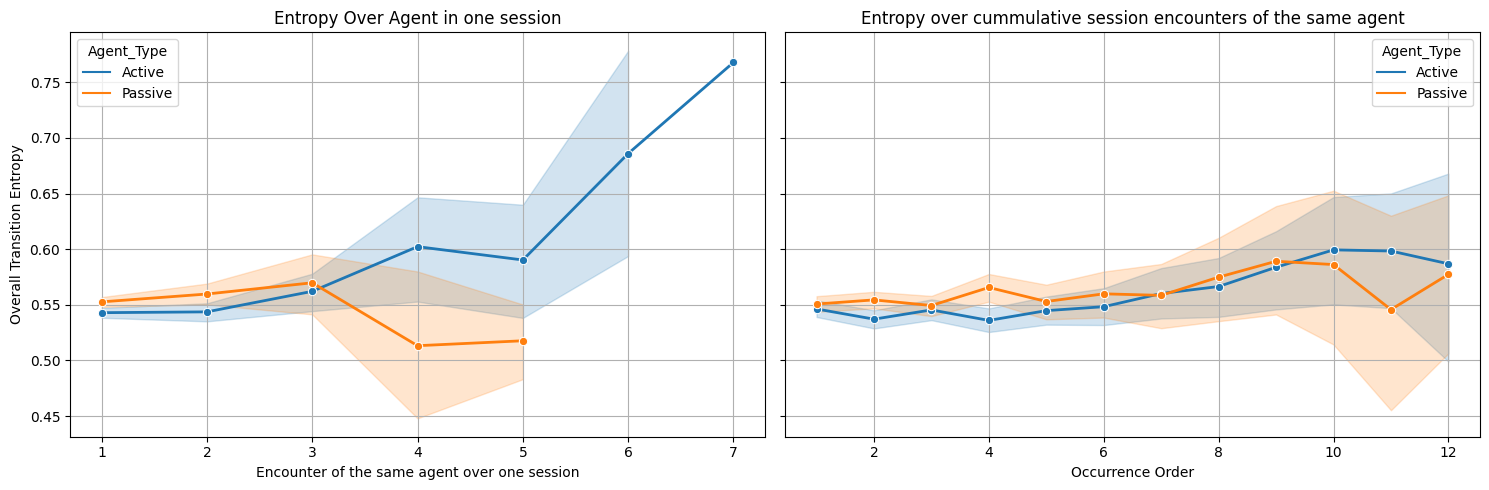

In [13]:
# Create a figure with two subplots: one for Encounter_Order and one for Occurrence_Order
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

# First plot: Encounter_Order vs. Overall Transition Entropy
sns.lineplot(
    data=stacked_df_ordered,
    x="Encounter_Order",
    y="Chao_Shen_Overall_Transition_Entropy",
    hue='Agent_Type',
    marker="o",
    linewidth=2,
    ax=axes[0]
)
axes[0].set_xlabel("Encounter of the same agent over one session")
axes[0].set_ylabel("Overall Transition Entropy")
axes[0].set_title("Entropy Over Agent in one session")
axes[0].grid(True)

# Second plot: Occurrence_Order vs. Overall Transition Entropy
sns.lineplot(
    data=stacked_df_ordered[stacked_df_ordered["Encounter_Order_Cummulative"] <= 12].copy(),
    x="Encounter_Order_Cummulative",
    y="Chao_Shen_Overall_Transition_Entropy",
    hue='Agent_Type',
    marker="o",
    linewidth=2,
    ax=axes[1]
)
axes[1].set_xlabel("Occurrence Order")
axes[1].set_ylabel("Overall Transition Entropy")
axes[1].set_title("Entropy over cummulative session encounters of the same agent")
axes[1].grid(True)

# Adjust layout and show plot
plt.tight_layout()
plt.show()


In [14]:
stacked_df_ordered.head()

,Trial_ID,Collider_Name,Occurrence_Order,Gaze_Sequence_Length,Chao_Shen_Overall_Transition_Entropy,Window_Start,Window_End,Chao_Shen_Transition_Entropy_Agent,Chao_Shen_Transition_Entropy_Task_Building,Chao_Shen_Transition_Entropy_Background,Chao_Shen_Transition_Entropy_Building,Chao_Shen_Transition_Entropy_Global_Landmark,Participant_ID,Session,Agent_ID,Agent_Type,Experiment,Encounter_Order,Encounter_Order_Cummulative
0,01_Cma_Trial_9,01_Cma,9,101,0.623664,2021-10-29 15:32:14.627663616,2021-10-29 15:32:44.627663616,0.000000,0.678922,0.599141,0.626422,NaN,365,1,1,Active,1,1,1
1,02_Cma_Trial_15,02_Cma,15,89,0.579162,2021-10-29 15:32:14.627663616,2021-10-29 15:32:44.627663616,1.142857,0.580841,0.823665,0.400738,NaN,365,1,2,Active,1,1,1
2,05_Cma_Trial_20,05_Cma,20,93,0.688441,2021-10-29 15:32:14.627663616,2021-10-29 15:32:44.627663616,0.000000,0.764393,0.650926,0.697329,NaN,365,1,5,Active,1,1,1
3,06_Cma_Trial_5,06_Cma,5,95,0.673898,2021-10-29 15:32:14.627663616,2021-10-29 15:32:44.627663616,0.769135,0.682157,0.640598,0.709503,NaN,365,1,6,Active,1,1,1
4,07_Cma_Trial_8,07_Cma,8,87,0.506429,2021-10-29 15:32:14.627663616,2021-10-29 15:32:44.627663616,0.000000,0.554397,0.508846,0.415238,0.638572,365,1,7,Active,1,1,1


In [15]:
stacked_df_ordered.columns

Index(['Trial_ID', 'Collider_Name', 'Occurrence_Order', 'Gaze_Sequence_Length',
       'Chao_Shen_Overall_Transition_Entropy', 'Window_Start', 'Window_End',
       'Chao_Shen_Transition_Entropy_Agent',
       'Chao_Shen_Transition_Entropy_Task_Building',
       'Chao_Shen_Transition_Entropy_Background',
       'Chao_Shen_Transition_Entropy_Building',
       'Chao_Shen_Transition_Entropy_Global_Landmark', 'Participant_ID',
       'Session', 'Agent_ID', 'Agent_Type', 'Experiment', 'Encounter_Order',
       'Encounter_Order_Cummulative'],
      dtype='object')

<Figure size 1200x500 with 0 Axes>

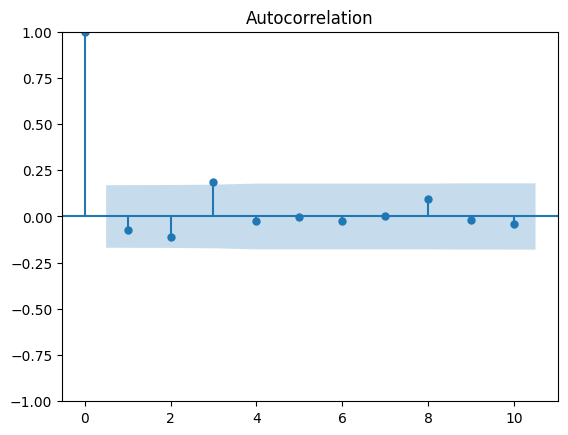

<Figure size 1200x500 with 0 Axes>

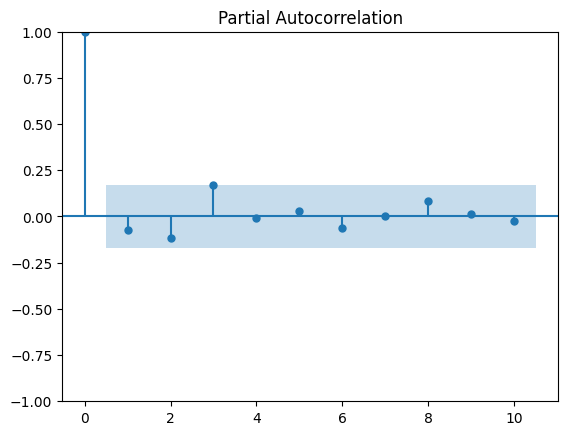

In [16]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Selecting one participant for analysis
example_pid = stacked_df_ordered["Participant_ID"].unique()[0]
subset = stacked_df_ordered[stacked_df_ordered["Participant_ID"] == example_pid]

# Plot ACF
plt.figure(figsize=(12, 5))
plot_acf(subset["Chao_Shen_Overall_Transition_Entropy"], lags=10)
plt.show()

# Plot PACF
plt.figure(figsize=(12, 5))
plot_pacf(subset["Chao_Shen_Overall_Transition_Entropy"], lags=10)
plt.show()


In [17]:
from statsmodels.tsa.stattools import adfuller

# Apply the test for one participant
result = adfuller(subset["Chao_Shen_Overall_Transition_Entropy"])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: -6.069214407757704
p-value: 1.1617375063056498e-07


In [18]:
from statsmodels.tsa.arima.model import ARIMA

# Fit ARIMA for one participant
model = ARIMA(subset["Chao_Shen_Overall_Transition_Entropy"], order=(1, 1, 1))
model_fit = model.fit()

# Show results
print(model_fit.summary())


                                        SARIMAX Results                                         
Dep. Variable:     Chao_Shen_Overall_Transition_Entropy   No. Observations:                  134
Model:                                   ARIMA(1, 1, 1)   Log Likelihood                  91.547
Date:                                  Fri, 07 Feb 2025   AIC                           -177.095
Time:                                          18:41:02   BIC                           -168.424
Sample:                                               0   HQIC                          -173.571
                                                  - 134                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1020      0.072     -1.413      0.158      -0.243

In [19]:
import pandas as pd
from statsmodels.tsa.statespace.sarimax import SARIMAX

# 2️⃣ **Add Session as an Interaction Term with Participant_ID**

# Convert Participant_ID and Session into categorical format for interaction effect
stacked_df_ordered["Participant_ID"] = stacked_df_ordered["Participant_ID"].astype("category")
stacked_df_ordered["Session"] = stacked_df_ordered["Session"].astype("category")

# Create interaction terms (Participant_ID * Session)
interaction_terms = pd.get_dummies(stacked_df_ordered["Participant_ID"].astype(str) + "_" + stacked_df_ordered["Session"].astype(str), drop_first=True)

# Fit SARIMAX with Participant_ID and Session Interaction
model_interaction = SARIMAX(
    stacked_df_ordered["Chao_Shen_Overall_Transition_Entropy"],
    order=(1, 0, 1),
    seasonal_order=(0, 0, 0, 0),  # No seasonality assumed
    exog=interaction_terms  # Include interaction terms
)
model_interaction_fit = model_interaction.fit()

# Print summary
print(model_interaction_fit.summary())

# 3️⃣ **Compare with a Mixed-Effects Model (Hierarchical Approach)**

import statsmodels.formula.api as smf

# Fit a Linear Mixed Effects Model (LMM) where Participant_ID is a random effect
lmm_model = smf.mixedlm("Chao_Shen_Overall_Transition_Entropy ~ Session", stacked_df_ordered, groups=stacked_df_ordered["Participant_ID"])
lmm_fit = lmm_model.fit()

# Print summary of mixed-effects model
print(lmm_fit.summary())



/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                        SARIMAX Results                                         
Dep. Variable:     Chao_Shen_Overall_Transition_Entropy   No. Observations:                10536
Model:                                 SARIMAX(1, 0, 1)   Log Likelihood                6098.925
Date:                                  Fri, 07 Feb 2025   AIC                         -11613.849
Time:                                          18:48:18   BIC                          -9493.184
Sample:                                               0   HQIC                        -10897.877
                                                - 10536                                         
Covariance Type:                                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
1031_2         0.5262      0.030     17.564      0.000       0.467

                      Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Chao_Shen_Overall_Transition_Entropy
No. Observations: 10536   Method:             REML                                
No. Groups:       59      Scale:              0.0189                              
Min. group size:  89      Log-Likelihood:     5852.6541                           
Max. group size:  304     Converged:          Yes                                 
Mean group size:  178.6                                                           
---------------------------------------------------------------------------------------
                    Coef.       Std.Err.        z         P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            0.541         0.006      91.838      0.000       0.529       0.552
Session[T.2]        -0.000         0.004      -0.009      0.993      -0.008       0.008
Se

/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


/Users/tracysanchezpacheco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


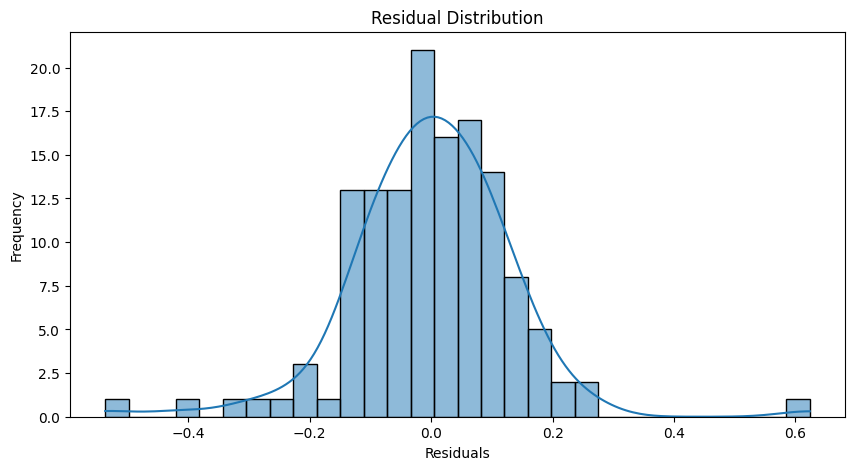

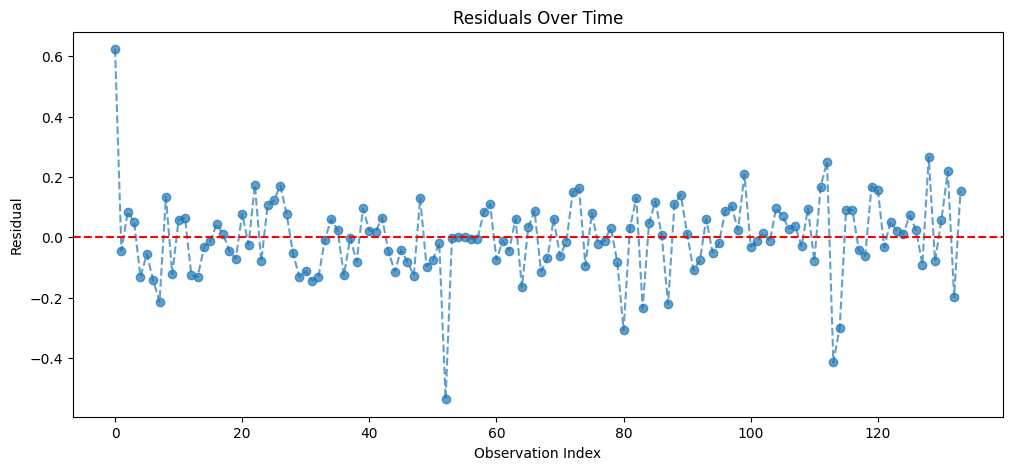

<Figure size 1200x500 with 0 Axes>

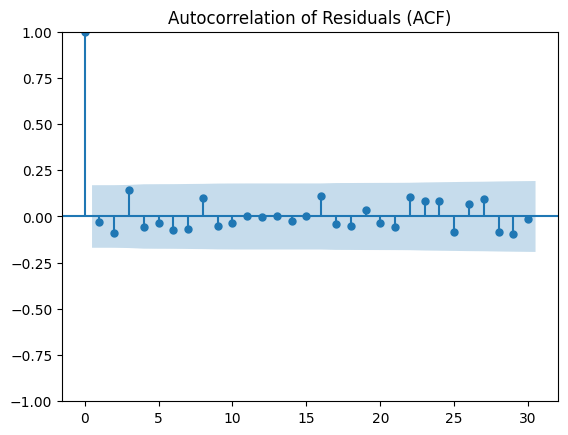

<Figure size 1200x500 with 0 Axes>

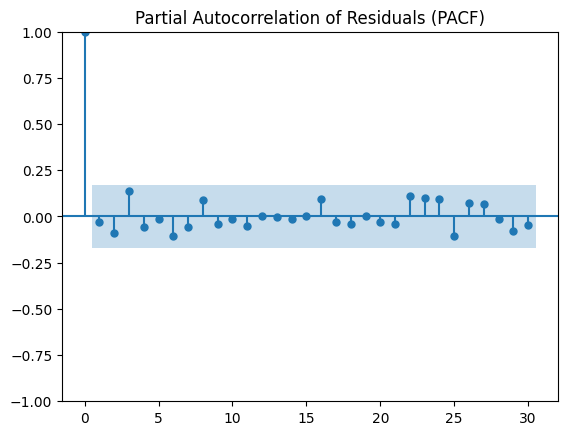

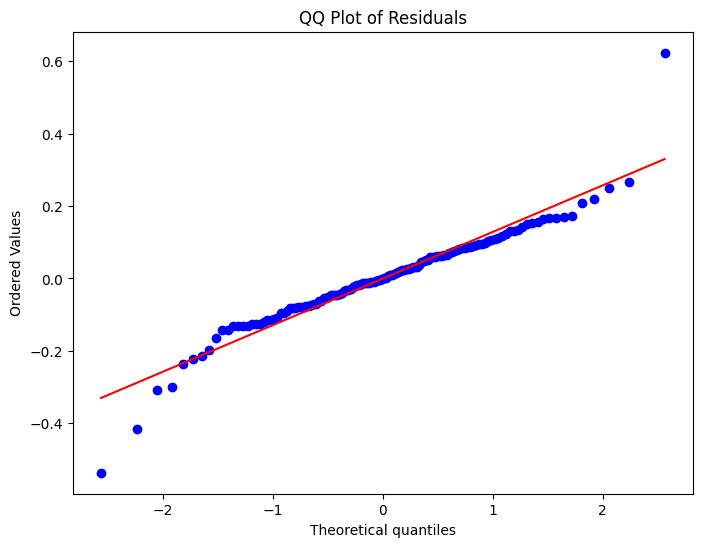

In [20]:


# Extract residuals from the SARIMAX model
residuals = model_fit.resid

# 1️⃣ **Plot Histogram of Residuals**
plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residual Distribution")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

# 2️⃣ **Plot Residuals Over Time**
plt.figure(figsize=(12, 5))
plt.plot(residuals, marker="o", linestyle="dashed", alpha=0.7)
plt.axhline(y=0, color="red", linestyle="--")
plt.title("Residuals Over Time")
plt.xlabel("Observation Index")
plt.ylabel("Residual")
plt.show()

# 3️⃣ **ACF of Residuals (Check for Remaining Autocorrelation)**
plt.figure(figsize=(12, 5))
plot_acf(residuals, lags=30)
plt.title("Autocorrelation of Residuals (ACF)")
plt.show()

# 4️⃣ **PACF of Residuals (Check Partial Autocorrelation)**
plt.figure(figsize=(12, 5))
plot_pacf(residuals, lags=30)
plt.title("Partial Autocorrelation of Residuals (PACF)")
plt.show()

# 5️⃣ **QQ Plot (Check for Normality)**
import scipy.stats as stats

fig, ax = plt.subplots(figsize=(8, 6))
stats.probplot(residuals, dist="norm", plot=ax)
plt.title("QQ Plot of Residuals")
plt.show()


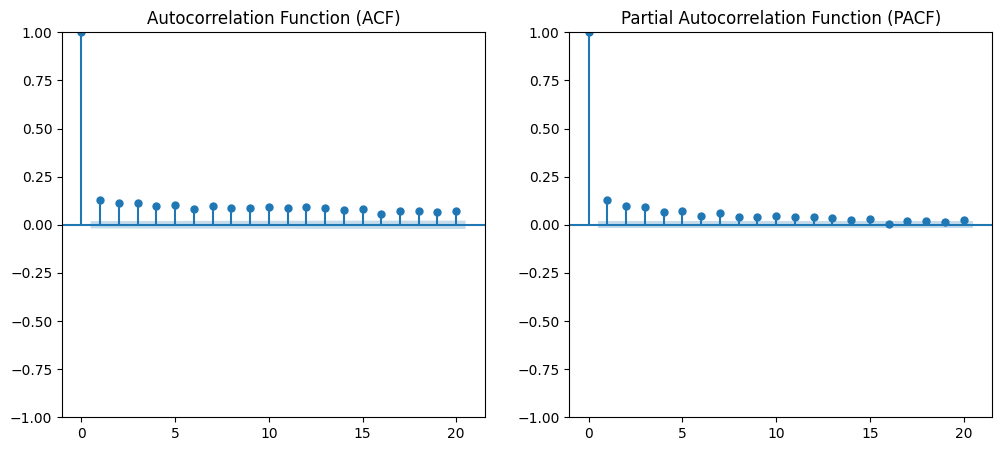

In [21]:
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Create figure for ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot ACF
sm.graphics.tsa.plot_acf(stacked_df_ordered["Chao_Shen_Overall_Transition_Entropy"], lags=20, ax=axes[0])
axes[0].set_title("Autocorrelation Function (ACF)")

# Plot PACF
sm.graphics.tsa.plot_pacf(stacked_df_ordered["Chao_Shen_Overall_Transition_Entropy"], lags=20, method="ywm", ax=axes[1])
axes[1].set_title("Partial Autocorrelation Function (PACF)")

plt.show()


In [22]:
stacked_df_ordered.columns

Index(['Trial_ID', 'Collider_Name', 'Occurrence_Order', 'Gaze_Sequence_Length',
       'Chao_Shen_Overall_Transition_Entropy', 'Window_Start', 'Window_End',
       'Chao_Shen_Transition_Entropy_Agent',
       'Chao_Shen_Transition_Entropy_Task_Building',
       'Chao_Shen_Transition_Entropy_Background',
       'Chao_Shen_Transition_Entropy_Building',
       'Chao_Shen_Transition_Entropy_Global_Landmark', 'Participant_ID',
       'Session', 'Agent_ID', 'Agent_Type', 'Experiment', 'Encounter_Order',
       'Encounter_Order_Cummulative'],
      dtype='object')

In [23]:
df.head()

NameError: name 'df' is not defined

In [ ]:
# Fit ARIMA(1,0,0) model
model = sm.tsa.ARIMA(stacked_df_ordered["Overall_Transition_Entropy"], order=(1, 0, 0))
results = model.fit()

# Print summary
print(results.summary())

In [ ]:
# Count the number of data points per session
session_counts = df.groupby("Session").size()

# Calculate the average session length
m = int(session_counts.mean())  # Convert to integer for SARIMA

print(f"Estimated Seasonal Parameter (m): {m}")


df = stacked_df_ordered.reset_index()
df["Overall_Transition_Entropy"] = pd.to_numeric(df["Overall_Transition_Entropy"], errors="coerce")

df_encoded = pd.get_dummies(df, columns=["Participant_ID"], drop_first=True)

# Ensure all columns are numeric
df_encoded = df_encoded.apply(pd.to_numeric, errors="coerce")

# Check data types
print(df_encoded.dtypes)

# Drop non-numeric columns from exog
exog = df_encoded.drop(columns=["Overall_Transition_Entropy"])

# Convert exog to numpy format
exog = exog.astype(float)


# Create dummy variables for each subject (one-hot encoding)
df_encoded = pd.get_dummies(df, columns=["Participant_ID"], drop_first=True)

import statsmodels.api as sm

sarima_model_mixed = sm.tsa.SARIMAX(
    df["Overall_Transition_Entropy"],
    exog=exog,
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, m)  # Use session-based seasonality
)

sarima_results_mixed = sarima_model_mixed.fit()
print(sarima_results_mixed.summary())






In [ ]:
exog

In [ ]:
# Check for missing values
print("Remaining missing values in exog:\n", exog.isna().sum())

# Check for infinite values
print("Remaining infinite values in exog:\n", (exog == np.inf).sum() + (exog == -np.inf).sum())

# Check data types
print("\nData Types in exog:")
print(exog.dtypes.value_counts())


In [ ]:
# Check for missing values in exog
print("Missing values in exog:\n", exog.isna().sum())

# Check for infinite values in exog
print("Infinite values in exog:\n", (exog == np.inf).sum() + (exog == -np.inf).sum())


In [ ]:
# Generate SARIMA forecast
forecast_steps = 30  # Predict next 30 time steps
sarima_forecast = sarima_results.get_forecast(steps=forecast_steps)
sarima_forecast_mean = sarima_forecast.predicted_mean
sarima_forecast_ci = sarima_forecast.conf_int()

# Generate ARIMA forecast for comparison
arima_forecast = results.get_forecast(steps=forecast_steps)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_ci = arima_forecast.conf_int()

# Generate forecast index
forecast_index = range(len(stacked_df_ordered), len(stacked_df_ordered) + forecast_steps)

# Plot SARIMA vs ARIMA Forecast
plt.figure(figsize=(12, 6))
plt.plot(stacked_df_ordered.index, stacked_df_ordered["Overall_Transition_Entropy"], label="Observed", color="blue")

# ARIMA Forecast
plt.plot(forecast_index, arima_forecast_mean, label="ARIMA Forecast", color="red", linestyle="dashed")
plt.fill_between(forecast_index, arima_forecast_ci.iloc[:, 0], arima_forecast_ci.iloc[:, 1], color='red', alpha=0.2)

# SARIMA Forecast
plt.plot(forecast_index, sarima_forecast_mean, label="SARIMA Forecast", color="green", linestyle="dashed")
plt.fill_between(forecast_index, sarima_forecast_ci.iloc[:, 0], sarima_forecast_ci.iloc[:, 1], color='green', alpha=0.2)

plt.title("Entropy Forecast: SARIMA vs. ARIMA")
plt.xlabel("Time")
plt.ylabel("Overall Transition Entropy")
plt.legend()
plt.grid()
plt.show()

# Testing Alternative SARIMA Models
# SARIMA(2,0,0)x(1,0,0,12)
sarima_model_alt = sm.tsa.SARIMAX(stacked_df_ordered["Overall_Transition_Entropy"], order=(2, 0, 0), seasonal_order=(1, 0, 0, 12))
sarima_results_alt = sarima_model_alt.fit()

# SARIMA(1,0,1)x(1,0,0,12)
sarima_model_alt2 = sm.tsa.SARIMAX(stacked_df_ordered["Overall_Transition_Entropy"], order=(1, 0, 1), seasonal_order=(1, 0, 0, 12))
sarima_results_alt2 = sarima_model_alt2.fit()

# Print model comparisons
sarima_comparison = pd.DataFrame({
    "Model": ["SARIMA(1,0,0)x(1,0,0,12)", "SARIMA(2,0,0)x(1,0,0,12)", "SARIMA(1,0,1)x(1,0,0,12)"],
    "AIC": [sarima_results.aic, sarima_results_alt.aic, sarima_results_alt2.aic],
    "BIC": [sarima_results.bic, sarima_results_alt.bic, sarima_results_alt2.bic]
})



In [ ]:
# Ensure forecast values and confidence intervals are properly formatted
forecast_steps = min(10, len(df))  # Predict up to 10 steps (or fewer if dataset is small)
forecast = results.get_forecast(steps=forecast_steps)

# Extract mean forecast and confidence intervals
forecast_mean = forecast.predicted_mean.astype(float)  # Convert to float
forecast_ci = forecast.conf_int().astype(float)  # Ensure confidence intervals are numeric

# Check for NaN or invalid values in forecast data
forecast_ci = forecast_ci.replace([np.inf, -np.inf], np.nan).dropna()

# Generate forecast index (extending from the original index)
forecast_index = list(range(len(df), len(df) + len(forecast_ci)))

# Plot original data and forecast with corrected data types
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["Overall_Transition_Entropy"], label="Observed", color="blue")
plt.plot(forecast_index, forecast_mean[: len(forecast_ci)], label="Forecast", color="red", linestyle="dashed")
plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)
plt.title("Entropy Forecast using ARIMA(1,0,0)")
plt.xlabel("Time")
plt.ylabel("Overall Transition Entropy")
plt.legend()
plt.grid()
plt.show()

# Ensure SARIMA model runs without issues
sarima_model = sm.tsa.SARIMAX(df["Overall_Transition_Entropy"], order=(1, 0, 0), seasonal_order=(1, 0, 0, 3))
sarima_results = sarima_model.fit()

# Print SARIMA model summary
sarima_results.summary()


In [ ]:
from causalimpact import CausalImpact

# Creating a time series format required for CausalImpact analysis
# Assuming an "event" occurs at a specific point (e.g., encountering a certain Agent_Type)
# We need a pre-event and post-event period
event_point = len(stacked_df_ordered) // 2  # Example: halfway through the dataset

# Constructing time series for causal impact analysis
time_series = stacked_df_ordered[["Overall_Transition_Entropy"]].copy()
time_series.index = pd.RangeIndex(start=1, stop=len(time_series) + 1, step=1)  # Simulating time index

# Defining pre- and post-event periods
pre_period = [1, event_point]  # Before encountering a specific agent
post_period = [event_point + 1, len(time_series)]  # After encountering the agent

# Running Causal Impact analysis
ci = CausalImpact(time_series, pre_period, post_period)
ci.plot()
ci.summary()


In [ ]:
import numpy as np
import pandas as pd
import skfda
from skfda.representation.basis import FourierBasis
from skfda.preprocessing.smoothing import BasisSmoother



# Reshape data: We need entropy values as a function of time (Occurrence_Order)
time_points = stacked_df_ordered["Occurrence_Order"].values
entropy_values = stacked_df_ordered["Overall_Transition_Entropy"].values

# Create a Fourier Basis (smooth functional representation)
basis = FourierBasis(domain_range=(min(time_points), max(time_points)), n_basis=6)

# Fit the entropy data using FDA smoothing
fd = skfda.FDataGrid(data_matrix=entropy_values.reshape(-1, 1), grid_points=time_points)
smoother = BasisSmoother(basis)
fd_smooth = smoother.fit_transform(fd)

# Plot smoothed entropy trajectories
fd_smooth.plot()


In [ ]:
stacked_df_ordered["Agent_ID"] = stacked_df_ordered["Agent_ID"].astype("category")
sns.heatmap(stacked_df_ordered[["Occurrence_Order", "Encounter_Order", "Session", "Agent_ID"]].corr(), annot=True, cmap="coolwarm")
plt.show()

In [ ]:
import statsmodels.api as sm
import statsmodels.formula.api as smf
model = smf.mixedlm("Overall_Transition_Entropy ~ Encounter_Order + Session + C(Agent_ID)", 
                     stacked_df_ordered, groups=stacked_df_ordered["Participant_ID"])
result = model.fit()
print(result.summary())  # Check model results

In [ ]:
# Fit a mixed-effects growth curve model
model = smf.mixedlm("Overall_Transition_Entropy ~ Session + Agent_Type + Occurrence_Order + Encounter_Order + I(Occurrence_Order**2)",
                     stacked_df_ordered, groups=stacked_df_ordered["Participant_ID"], re_formula="~Occurrence_Order")
result = model.fit()
print(result.summary())  # Check model results

In [ ]:
grouped_for_LMM[(grouped_for_LMM.Participant_ID == 1031) & (grouped_for_LMM.Experiment == 2) ]

In [ ]:
stacked_df_ordered[(stacked_df_ordered.Participant_ID == 1031) & (stacked_df_ordered.Experiment == 1) ]

In [ ]:
valid_combinations

In [ ]:
print(stacked_df_ordered[['Participant_ID', 'Experiment']].drop_duplicates())


In [ ]:
Chao = pd.read_csv("/Volumes/TwoTeras/1_Experiment_2/Entropy_Results/grouped_for_LMM_Chao_Shen.csv")

In [ ]:
Chao.head()

In [ ]:
grouped_for_LMM.head()

In [ ]:
# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)
sns.boxplot(data=grouped_by_session, x='Agent_ID', y='mean', hue='Experiment', palette=experiment_palette)

In [ ]:


# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)
grouped_by_session_Active = grouped_by_session[grouped_by_session.Agent_Type == "Active"]
# Add a new column for Experiment_Type
grouped_by_session_Active["Experiment_Type"] = grouped_by_session_Active["Experiment"].apply(lambda x: "Congruent" if x == 1 else "Incongruent")


# Calculate the overall mean of Transition_Entropy_Active_Agent
overall_mean = grouped_by_session_Active['mean'].mean()

# Plotting combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_by_session, x='Session', y='mean', hue='Experiment', palette=experiment_palette)

# Add a red horizontal line for the overall mean
plt.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Set labels and title
plt.title("Boxplot of Overall Transitional Entropy for active agents")
plt.xlabel("Session")
plt.ylabel("Transitional Entropy")
plt.legend(title="Experiment", loc='upper left', bbox_to_anchor=(1.05, 1))
plt.tight_layout()
plt.show()

In [ ]:
grouped_by_session_active = grouped_by_session[grouped_by_session.Agent_Type == "Active"]

# Generate a palette with two colors, one for each experiment
experiment_palette = sns.color_palette("YlGnBu", 2)

# Calculate the overall mean of Transition_Entropy_Active_Agent
overall_mean = grouped_by_session_active['mean'].mean()

# Plotting combined boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=grouped_by_session_active, x='Session', y='mean', hue='Experiment', palette=experiment_palette)

# Add a red horizontal line for the overall mean
plt.axhline(overall_mean, color='red', linestyle='--', linewidth=1.5, label=f'Overall Mean: {overall_mean:.2f}')

# Set labels and title
plt.title("Boxplot of Transition Entropy for Agent gazes by Session")
plt.xlabel("Session")
plt.ylabel("Transitional Entropy")
plt.legend(title="Condition")
plt.tight_layout()
plt.show()